In [1]:
#import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

In [2]:
# loading data 
compound_table = pd.read_parquet('compound_table.parquet')
compound_table.sort_values('id', ascending=True, inplace=True)
compound_table.rename(columns={'id': 'compound_id'}, inplace=True)
electrochem_table = pd.read_parquet('electrochem_table.parquet')


In [3]:
# creating merged table
combined_table = compound_table.merge(electrochem_table, how='right', on='compound_id')
combined_table= combined_table[['compound_id', 'name', 'formula', 'recyclable', 'type', 'compound_family',
       'id', 'redox_potential_V', 'reference_electrode',
       'electrolyte', 'solvent', 'pH', 'used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'measurement_ref'
       ]]

In [4]:
# data cleaning
# merging similar families
combined_table.loc[combined_table.compound_family=='dialkyloxybenzene', 'compound_family'] = 'dialkoxybenzene'
# checking category binary
combined_table.loc[combined_table.used_in_photocat!=1, 'used_in_photocat'] = 0
# splitting aqueous non-aqueous
combined_table['aqueous'] = 0
combined_table.loc[combined_table.solvent=='water', 'aqueous']=1
# adding DSSC indicator
combined_table['used_in_DSSC'] = 0
combined_table.loc[combined_table.compound_id.isin([33, 39]), 'used_in_DSSC'] = 1


In [5]:
print(f"Table contains data for {combined_table.compound_id.nunique()} compounds:")
print(f"compound_family: {combined_table.compound_family.nunique()} distinct")
print(f"type: {combined_table.type.nunique()} distinct")
print(f"solvent: {combined_table.solvent.nunique()} distinct")
print(f"{combined_table.loc[combined_table.aqueous==1, 'compound_id'].nunique()} compounds with redox potentials measured in aqueous media")

Table contains data for 35 compounds:
compound_family: 12 distinct
type: 3 distinct
solvent: 9 distinct
17 compounds with redox potentials measured in aqueous media


In [6]:
display(combined_table[['compound_family', 'type', 'compound_id', 'id']].groupby(['type', 'compound_family']).nunique())

compound_id  id
type              compound_family                         
electron acceptor dialkylquinoxaline                 1   2
                  viologen                           3   3
electron donor    TEMPO                              2   2
                  amine                              5   5
                  benzimidazole                      7   7
                  dialkoxybenzene                    3   4
                  disulfide forming                  2   2
                  ferrocene                          3   3
                  nicotinamide biomimetic            1   1
                  organic acid                       1   1
                  quinone                            3   4
photosensitizer   organometallic                     3  11

In [7]:
# setting aqueous data to one reference redox potentials
print(combined_table.loc[combined_table.aqueous==1,'reference_electrode'].unique())
print(combined_table.loc[combined_table.aqueous==1,'pH'].unique())

['SCE' 'NHE' 'SHE' 'Ag|AgCl']
[nan 7.  0.  0.7]


In [8]:
print(combined_table.loc[combined_table.aqueous!=1,'reference_electrode'].unique())

['SCE' 'SHE' 'Li|Li+' 'Fc/Fc+' 'NHE' 'Ag|AgNO3']


In [9]:
print(combined_table.loc[combined_table.reference_electrode=='Li|Li+', 'solvent'].unique())

['EC/PC/EMC' 'PC' 'EC/EMC' 'PEC']


In [10]:
print(combined_table.loc[combined_table.aqueous!=1, 'solvent'].unique())

['acetonitrile' 'THF' 'EC/PC/EMC' 'PC' 'EC/EMC' 'PEC' 'MeCN' 'DMF']


In [11]:
# reference electrode potentials from Bard and Faulkner Electrochemical Methods Fundamentals and Applications 2nd Ed.
aqueous_references = {'SCE': 0.0,
                      'NHE': 0.242,
                      'SHE': 0.242,
                      'Ag|AgCl': 0.045
                    }
for ref, correction_V in aqueous_references.items():
    combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous==1), 'redox_potential_V'] = combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous==1), 'redox_potential_V'] + correction_V
    combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous==1), 'reference_electrode'] = 'SCE'

In [12]:
# reference electrode potentials from Bard and Faulkner Electrochemical Methods Fundamentals and Applications 2nd Ed.
# nonaq_references = {'Fc/Fc+': 0.0,
#                     'SCE': -0.31, # Bard & Faulkner
#                     'NHE': -0.31 + 0.242, # Bard & Faulkner Fc vs. SCE + NHE corr
#                     'SHE': -0.31 + 0.242, # Bard & Faulkner Fc vs. SCE + SHE corr
#                     'Ag|AgNO3': 0.0, # need a reference for this
#                     'Li|Li+': {'MeCN': -3.3, 'carbonate (using PC)': -3.4},# values extracted from Journal of The Electrochemical Society, 164 (12) A2295-A2297 (2017)
#                     }

# for ref, correction_V in nonaq_references.items():
#     if ref not in ['Ag|AgNO3', 'Li|Li+']:
#         combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous!=1), 'redox_potential_V'] = combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous==1), 'redox_potential_V'] + correction_V
#         combined_table.loc[(combined_table.reference_electrode==ref) & (combined_table.aqueous!=1), 'reference_electrode'] = 'Fc/Fc+'
# lithium_correction = nonaq_references['Li|Li+']
# solvents_wo_MeCN = [s for s in list(combined_table.solvent.unique()) if s in ['acetonitrile', 'MeCN']]
# combined_table.loc[(combined_table.reference_electrode=='Li|Li+') && (combined_table.solvent.isin(['acetonitrile', 'MeCN'])), 'redox_potential_V'] = lithium_correction['MeCN'] + combined_table.loc[(combined_table.reference_electrode=='Li|Li+') && (combined_table.solvent.isin(['acetonitrile', 'MeCN'])), 'redox_potential_V']


In [13]:
# split photosensitizers into a different table
ps_table = combined_table.loc[combined_table.type=='photosensitizer', :].copy(deep=True)
rsd_table = combined_table.loc[combined_table.type!='photosensitizer', :].copy(deep=True)

In [14]:
display(rsd_table[['compound_family', 'compound_id', 'aqueous', 'used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'used_in_DSSC']].groupby(['aqueous', 'compound_family','used_in_photocat', 'used_in_rfbs', 'used_as_hcarrier', 'used_in_DSSC']).nunique())

compound_id
aqueous compound_family         used_in_photocat used_in_rfbs used_as_hcarrier used_in_DSSC             
0       amine                   0.0              0.0          0.0              0                       1
                                                              1.0              0                       1
                                1.0              0.0          0.0              0                       1
        benzimidazole           1.0              0.0          0.0              0                       6
                                                              1.0              0                       1
        dialkoxybenzene         0.0              1.0          0.0              0                       3
        dialkylquinoxaline      0.0              1.0          0.0              0                       1
        disulfide forming       0.0              0.0          0.0              1                       2
        quinone                 0.0              0.0          1.0              0                       1
1       TEMPO                   0.0              1.0          0.0              0                       2
        amine                   1.0              0.0          0.0              0                       2
        ferrocene               0.0              1.0          0.0              0                       3
        nicotinamide biomimetic 1.0              0.0          0.0              0                       1
        organic acid            1.0              0.0          0.0              0                       1
        quinone                 0.0              0.0          1.0              0                       2
                                                 1.0          1.0              0                       1
        viologen                0.0              1.0          0.0              0                       3

In [19]:
ps_table['redox_event'] = ''
ps_table.loc[ps_table.id.isin([33,]), 'redox_event'] = 'Ered'
ps_table.loc[ps_table.id.isin([34,]), 'redox_event'] = 'Ered*'
ps_table.loc[ps_table.id.isin([35,]), 'redox_event'] = 'Eox'
ps_table.loc[ps_table.id.isin([36,]), 'redox_event'] = 'Eox*'
#display(ps_table)

,compound_id,name,formula,recyclable,type,compound_family,id,redox_potential_V,reference_electrode,electrolyte,solvent,pH,used_in_photocat,used_in_rfbs,used_as_hcarrier,measurement_ref,aqueous,used_in_DSSC,redox_event
32,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,33,-1.038,SCE,,water,NaN,1.0,0.0,0.0,Balzani book page 199,1,0,Ered
33,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,34,1.082,SCE,,water,NaN,1.0,0.0,0.0,Balzani book page 199,1,0,Ered*
34,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,35,1.502,SCE,,water,NaN,1.0,0.0,0.0,Balzani book page 199,1,0,Eox
35,36,"[Ru(bpy)3]2+ Tris(2,2-bipyridyl)ruthenium(II)...",C30H36Cl2N6O6Ru,1.0,photosensitizer,organometallic,36,-0.618,SCE,,water,NaN,1.0,0.0,0.0,Balzani book page 199,1,0,Eox*
36,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,37,-0.770,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,
37,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,38,-0.300,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,
38,37,[Ir(tpy)3]3+,,1.0,photosensitizer,organometallic,39,1.940,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,
39,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,40,0.690,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,
40,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,41,-1.680,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,
41,38,[Cu(dpp)]+,,1.0,photosensitizer,organometallic,42,-1.110,SCE,,acetonitrile,NaN,1.0,0.0,0.0,Balzani book page 199,0,0,


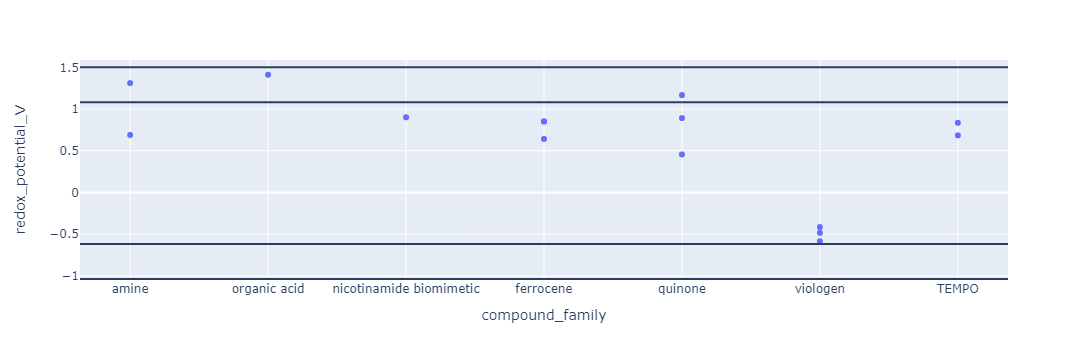

In [22]:
aqueous = px.scatter(rsd_table.loc[rsd_table.aqueous==1,:], x='compound_family', y='redox_potential_V')
id_list = ps_table.loc[(ps_table.compound_id==36)&(ps_table.aqueous==1),:].id.to_list()
for idnum in id_list:
    aqueous.add_hline(y=float(ps_table.loc[ps_table.id==idnum, 'redox_potential_V']))
aqueous.show()